1. Drop out;
2. Data augmentation;
3. Weight sharing.

In [1]:
# library
# standard library
import os

# third-party library
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
import dlc_practical_prologue as helper

In [3]:
def plot_images(images, labels):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].squeeze(), cmap='gray')
        xlabel = "True: {0}".format(labels[i])
        ax.set_xlabel(xlabel)
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
        
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

---
### Siamese network with auxiliary loss

We do not use drop out in siamese network because we cannot promise for one pair of images, for each image the same nodes are dropped out.

In [4]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(5),
    transforms.ToTensor()
])

class rotated_dataset():
    def __init__(self, data, transform=transform):
        self.data = data
        self.transform = transform

    def __getitem__(self,idx1,idx2):
        item = self.data[idx1][idx2].unsqueeze(0)
        item = self.transform(item)
        return item.squeeze()
    
    def __rotate__(self):
        trans_img = torch.zeros_like(self.data)
        for i in range(trans_img.shape[0]):
            for j in range(trans_img.shape[1]):
                trans_img[i][j] = self.__getitem__(i,j)
        return trans_img

In [5]:
def compute_nb_errors(model, input, target):
    nb_errors = []
    num_round = 20
    mini_batch_size = input.size(0)//num_round
    for i in range(num_round):
        b = i*mini_batch_size
        output = model(input.narrow(0, b, mini_batch_size))[0]
        target_patch = target.narrow(0, b, mini_batch_size)
        _,output = output.max(1)
        nb_errors.append((output != target_patch).sum().data.item()/mini_batch_size)
    nb_tensor = torch.FloatTensor(nb_errors)
    return nb_tensor.mean().item(),nb_tensor.std().item()

In [6]:
class baseline(nn.Module):
    def __init__(self):
        super(baseline, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (2, 14, 14)
            nn.Conv2d(
                in_channels=2,              # input height
                out_channels=16,            # n_filters
                kernel_size=2,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              # output shape (16, 28, 28)
#             nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 64, 2, 1, 1),     # output shape (32, 14, 14)
#             nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.conv3 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(64, 128, 2, 1, 1),     # output shape (32, 14, 14)
#             nn.Dropout(0.5),
            nn.BatchNorm2d(128),
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                # output shape (32, 7, 7)
        )
        self.fc1 = nn.Linear(128 *2 * 2, 64)
        self.fc2 = nn.Linear(64, 20)
        self.out = nn.Linear(20,2)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        output = self.out(x)
        return output,x

base = baseline()
pytorch_total_params = sum(p.numel() for p in base.parameters() if p.requires_grad)
print(pytorch_total_params)
print(base)  # net architecture


71790
baseline(
  (conv1): Sequential(
    (0): Conv2d(2, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=20, bias=True)
  (ou

In [7]:
class CNN_Siamese(nn.Module):
    def __init__(self):
        super(CNN_Siamese, self).__init__()
        self.conv1 = nn.Sequential(         # input shape (1, 14, 14)
            nn.Conv2d(
                in_channels=1,              # input height
                out_channels=16,            # n_filters
                kernel_size=2,              # filter size
                stride=1                   # filter movement/step
                              # if want same width and length of this image after con2d, padding=(kernel_size-1)/2 if stride=1
            ),                              
#             nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),    # choose max value in 2x2 area, output shape (16, 14, 14)
        )
        self.conv2 = nn.Sequential(         # input shape (16, 14, 14)
            nn.Conv2d(16, 64, 2, 1, 1),     
#             nn.Dropout(0.5),
            nn.ReLU(),                      # activation
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),                
        )
        self.conv3 = nn.Sequential(         
            nn.Conv2d(64, 128, 2, 1, 1),     
#             nn.Dropout(0.5),
            nn.BatchNorm2d(128),
            nn.ReLU(),                      # activation
            nn.MaxPool2d(2),                
        )
        self.fc1 = nn.Linear(128 *2 * 2, 64)
        self.fc2 = nn.Linear(64, 10)
        self.out = nn.Linear(20,2)

    def forward_once(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        output = self.fc2(x)
        return output,x
    
    def forward(self,x):
        input1 = x.narrow(1,0,1)
        input2 = x.narrow(1,1,1)
        output1,last_layer1 = self.forward_once(input1)
        output2,last_layer2 = self.forward_once(input2)
        output = torch.cat([output1,output2],dim=1)
        output = self.out(output).squeeze()
        return output,last_layer1,last_layer2,output1,output2
        
cnn_siamese = CNN_Siamese()
pytorch_total_params = sum(p.numel() for p in cnn_siamese.parameters() if p.requires_grad)
print(pytorch_total_params)
print(cnn_siamese)  # net architecture

71076
CNN_Siamese(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(2, 2), stride=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=512, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
  

In [8]:
train_input, train_target, train_classes, test_input, test_target, test_classes = helper.generate_pair_sets(1000)

augumented_data = rotated_dataset(train_input).__rotate__()
shuffle_index = torch.randperm(1000)
train_input = torch.cat((train_input,augumented_data.data),0)
train_classes = torch.cat((train_classes, train_classes), 0)
train_target = torch.cat((train_target, train_target), 0)

train_input, train_classes, train_target = train_input[shuffle_index], train_classes[shuffle_index], train_target[shuffle_index]

# augumented_data = rotated_dataset(test_input).__rotate__()
augumented_data = test_input
shuffle_index = torch.randperm(1000)
test_input = torch.cat((test_input,augumented_data.data),0)
test_classes = torch.cat((test_classes, test_classes), 0)
test_target = torch.cat((test_target, test_target), 0)
test_input, test_classes, test_target = test_input[shuffle_index], test_classes[shuffle_index], test_target[shuffle_index]


In [9]:
train_set = {}
train_set['input'] = train_input
train_set['classes'] = train_classes
train_set['target'] = train_target

test_set = {}
test_set['input'] = test_input
test_set['classes'] = test_classes
test_set['target'] = test_target

In [10]:
images = augumented_data.data.narrow(0,0,9).narrow(1,0,1)
labels = test_classes.narrow(0,0,9).narrow(1,0,1)

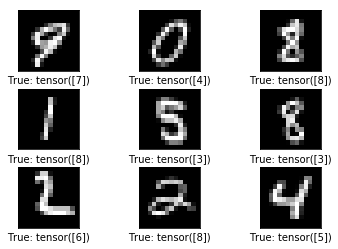

In [11]:
plot_images(images,labels)

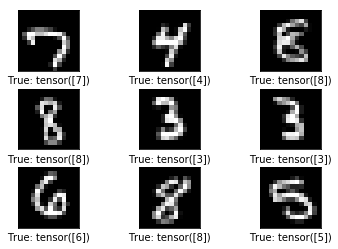

In [12]:
plot_images(test_input.narrow(0,0,9).narrow(1,0,1),labels)

---

In [13]:
def ModelTest(model_,train_set,test_set,auxiliary_loss,mini_batch_size=100,EPOCH=25,LR=0.001):
    
    model = model_
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)   # optimize all cnn parameters
    criterion = nn.CrossEntropyLoss()                       # the target label is not one-hotted

    train_input = train_set['input']
    train_classes = train_set['classes']
    train_target = train_set['target']
    
    test_input = test_set['input']
    test_classes = test_set['classes']
    test_target = test_set['target']
    
    for epoch in range(EPOCH):
        for b in range(0, train_input.size(0), mini_batch_size):   # gives batch data, normalize x when iterate train_loader

            x_tr = train_input.narrow(0, b, mini_batch_size)
            y_tr_class = train_classes.narrow(0, b, mini_batch_size)
            y_tr_target = train_target.narrow(0, b, mini_batch_size)#.float()
            x_tr = Variable(x_tr)   # batch x
            y_tr_class = Variable(y_tr_class)   # batch y
            
            if auxiliary_loss:
                if model_.__class__.__name__ == 'baseline':
                    output,last_layer1 = model(x_tr)[0:2]
                    loss = criterion(last_layer1, y_tr_class.narrow(1,0,1).squeeze()) + criterion(output, y_tr_target)
                else:
                    output,last_layer1,last_layer2,output1,output2 = model(x_tr)               # cnn output
                    auxiliary_loss = criterion(output1, y_tr_class.narrow(1,0,1).squeeze())+criterion(output2, y_tr_class.narrow(1,1,1).squeeze())
                    loss = auxiliary_loss + 0.3*criterion(output,y_tr_target)   # cross entropy loss
            else:
                output,last_layer1 = model(x_tr)[0:2]               # cnn output
                loss = criterion(output, y_tr_target)   # cross entropy loss                
            
            optimizer.zero_grad()           # clear gradients for this training step
            loss.backward()                 # backpropagation, compute gradients
            optimizer.step()                # apply gradients

        train_error_mean,train_error_std = compute_nb_errors(model, train_input, train_target)
        test_error_mean, test_error_std = compute_nb_errors(model, test_input, test_target)

        print('Epoch: ', epoch, '| train loss: %.4f' % loss.data.item(), '| train error: %.2f' % train_error_mean)
        print('Epoch: ', epoch, '| test error: %.2f' % test_error_mean,'|standard deviation: %.2f'%test_error_std,'\n\n')
    
    return model, last_layer1

In [15]:
model_siamese_noaux, last_layer_siamese_noaux = ModelTest(CNN_Siamese(),train_set,test_set,
                                           auxiliary_loss=False,mini_batch_size=100,EPOCH=25,LR=0.001)

Epoch:  0 | train loss: 0.5829 | train error: 0.32
Epoch:  0 | test error: 0.34 |standard deviation: 0.07 


Epoch:  1 | train loss: 0.3886 | train error: 0.19
Epoch:  1 | test error: 0.25 |standard deviation: 0.05 


Epoch:  2 | train loss: 0.2601 | train error: 0.14
Epoch:  2 | test error: 0.22 |standard deviation: 0.05 


Epoch:  3 | train loss: 0.1952 | train error: 0.10
Epoch:  3 | test error: 0.21 |standard deviation: 0.06 


Epoch:  4 | train loss: 0.1242 | train error: 0.05
Epoch:  4 | test error: 0.20 |standard deviation: 0.05 


Epoch:  5 | train loss: 0.0728 | train error: 0.02
Epoch:  5 | test error: 0.18 |standard deviation: 0.04 


Epoch:  6 | train loss: 0.0345 | train error: 0.00
Epoch:  6 | test error: 0.19 |standard deviation: 0.05 


Epoch:  7 | train loss: 0.0139 | train error: 0.00
Epoch:  7 | test error: 0.20 |standard deviation: 0.05 


Epoch:  8 | train loss: 0.0061 | train error: 0.00
Epoch:  8 | test error: 0.19 |standard deviation: 0.05 


Epoch:  9 | train l

In [14]:
model_siamese, last_layer_siamese = ModelTest(CNN_Siamese(),train_set,test_set,
                                           auxiliary_loss=True,mini_batch_size=100,EPOCH=25,LR=0.001)

Epoch:  0 | train loss: 3.0712 | train error: 0.50
Epoch:  0 | test error: 0.53 |standard deviation: 0.07 


Epoch:  1 | train loss: 1.7200 | train error: 0.48
Epoch:  1 | test error: 0.50 |standard deviation: 0.07 


Epoch:  2 | train loss: 1.0713 | train error: 0.44
Epoch:  2 | test error: 0.45 |standard deviation: 0.08 


Epoch:  3 | train loss: 0.7855 | train error: 0.38
Epoch:  3 | test error: 0.38 |standard deviation: 0.06 


Epoch:  4 | train loss: 0.6056 | train error: 0.32
Epoch:  4 | test error: 0.34 |standard deviation: 0.05 


Epoch:  5 | train loss: 0.4618 | train error: 0.28
Epoch:  5 | test error: 0.29 |standard deviation: 0.05 


Epoch:  6 | train loss: 0.3640 | train error: 0.25
Epoch:  6 | test error: 0.25 |standard deviation: 0.06 


Epoch:  7 | train loss: 0.2959 | train error: 0.21
Epoch:  7 | test error: 0.22 |standard deviation: 0.05 


Epoch:  8 | train loss: 0.2407 | train error: 0.18
Epoch:  8 | test error: 0.20 |standard deviation: 0.05 


Epoch:  9 | train l

In [16]:
model_base, last_layer_base = ModelTest(baseline(),train_set,test_set,
                                           auxiliary_loss=False,mini_batch_size=100,EPOCH=25,LR=0.001)

Epoch:  0 | train loss: 0.5909 | train error: 0.29
Epoch:  0 | test error: 0.31 |standard deviation: 0.07 


Epoch:  1 | train loss: 0.4185 | train error: 0.22
Epoch:  1 | test error: 0.26 |standard deviation: 0.06 


Epoch:  2 | train loss: 0.3091 | train error: 0.15
Epoch:  2 | test error: 0.23 |standard deviation: 0.05 


Epoch:  3 | train loss: 0.2364 | train error: 0.08
Epoch:  3 | test error: 0.23 |standard deviation: 0.05 


Epoch:  4 | train loss: 0.1609 | train error: 0.04
Epoch:  4 | test error: 0.24 |standard deviation: 0.06 


Epoch:  5 | train loss: 0.0650 | train error: 0.15
Epoch:  5 | test error: 0.29 |standard deviation: 0.08 


Epoch:  6 | train loss: 0.0914 | train error: 0.01
Epoch:  6 | test error: 0.23 |standard deviation: 0.05 


Epoch:  7 | train loss: 0.0169 | train error: 0.03
Epoch:  7 | test error: 0.27 |standard deviation: 0.06 


Epoch:  8 | train loss: 0.0185 | train error: 0.07
Epoch:  8 | test error: 0.27 |standard deviation: 0.07 


Epoch:  9 | train l

In [17]:
model_base_AL, last_layer_base_AL = ModelTest(baseline(),train_set,test_set,
                                           auxiliary_loss=True,mini_batch_size=100,EPOCH=25,LR=0.001)

Epoch:  0 | train loss: 2.8754 | train error: 0.41
Epoch:  0 | test error: 0.41 |standard deviation: 0.09 


Epoch:  1 | train loss: 2.4997 | train error: 0.33
Epoch:  1 | test error: 0.35 |standard deviation: 0.08 


Epoch:  2 | train loss: 2.0532 | train error: 0.29
Epoch:  2 | test error: 0.31 |standard deviation: 0.07 


Epoch:  3 | train loss: 1.6834 | train error: 0.25
Epoch:  3 | test error: 0.28 |standard deviation: 0.07 


Epoch:  4 | train loss: 1.3442 | train error: 0.21
Epoch:  4 | test error: 0.26 |standard deviation: 0.07 


Epoch:  5 | train loss: 1.0678 | train error: 0.17
Epoch:  5 | test error: 0.25 |standard deviation: 0.07 


Epoch:  6 | train loss: 0.8344 | train error: 0.14
Epoch:  6 | test error: 0.24 |standard deviation: 0.07 


Epoch:  7 | train loss: 0.6441 | train error: 0.10
Epoch:  7 | test error: 0.23 |standard deviation: 0.06 


Epoch:  8 | train loss: 0.4877 | train error: 0.07
Epoch:  8 | test error: 0.22 |standard deviation: 0.06 


Epoch:  9 | train l

In [18]:
# following function (plot_with_labels) is for visualization, can be ignored if not interested
from matplotlib import cm
from sklearn.manifold import TSNE

def plot_with_labels(lowDWeights, labels,title):
    plt.figure(figsize=(10,6))
    plt.cla()
    X, Y = lowDWeights[:, 0], lowDWeights[:, 1]
    for x, y, s in zip(X, Y, labels):
        c = cm.rainbow(int(255 * s / 9)); plt.text(x, y, s, backgroundcolor=c, fontsize=9)
    plt.xlim(X.min(), X.max()); plt.ylim(Y.min(), Y.max()); plt.title('Visualize last layer of %s'%title)
    plt.savefig(title+'.jpg')
    plt.show(); plt.pause(0.01)
plt.ion()

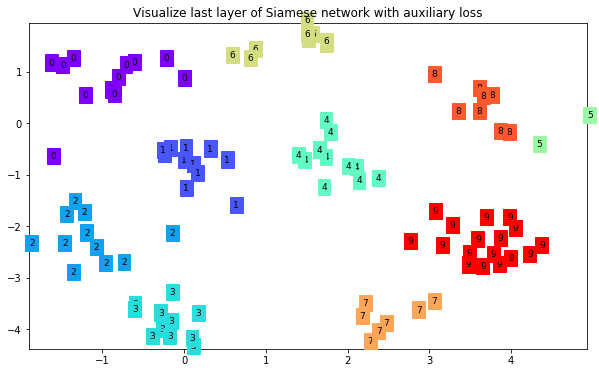

In [19]:
last_layer = last_layer_siamese
y_tr_class = train_classes.narrow(0, 900, 100)
tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = y_tr_class.narrow(1,0,1).squeeze().numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels,'Siamese network with auxiliary loss')
plt.ioff()


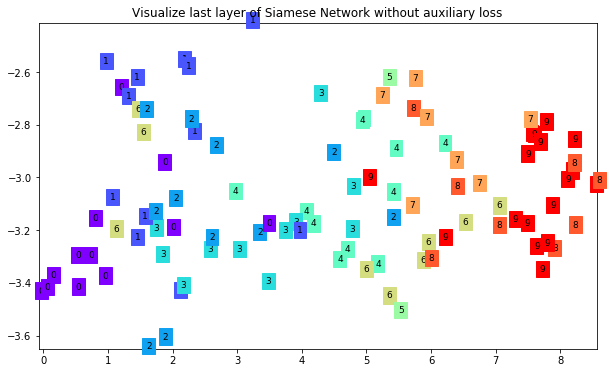

In [20]:
last_layer = last_layer_siamese_noaux

tsne = TSNE(perplexity=50, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = y_tr_class.narrow(1,0,1).squeeze().numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels,'Siamese Network without auxiliary loss')
plt.ioff()

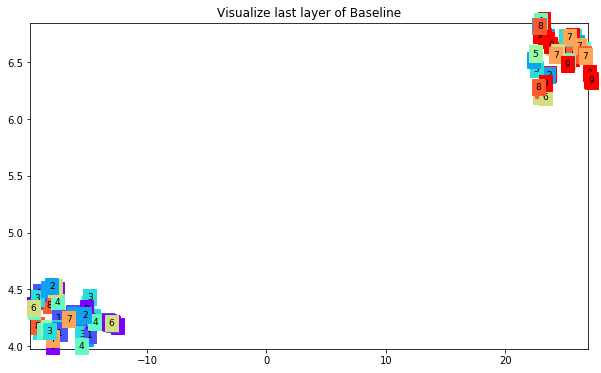

In [21]:
last_layer = last_layer_base

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = y_tr_class.narrow(1,0,1).squeeze().numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels,'Baseline')
plt.ioff()


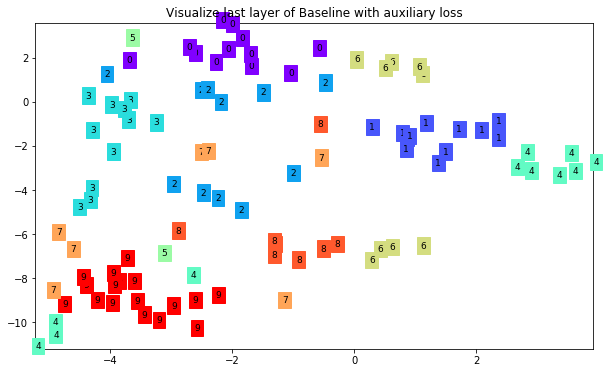

In [22]:
last_layer = last_layer_base_AL

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
plot_only = 500
low_dim_embs = tsne.fit_transform(last_layer.data.numpy()[:plot_only, :])
labels = y_tr_class.narrow(1,0,1).squeeze().numpy()[:plot_only]
plot_with_labels(low_dim_embs, labels,'Baseline with auxiliary loss')
plt.ioff()


In [26]:
last_layer_base.data.shape

torch.Size([100, 20])

In [23]:
last_layer_base_AL.data.shape

torch.Size([100, 20])

In [24]:
last_layer_siamese.data.shape

torch.Size([100, 64])

In [25]:
last_layer_siamese_noaux.data.shape

torch.Size([100, 64])

---